<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/week4/Thursday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install

In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers import UNet1DModel

2025-06-26 13:25:45.077493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750944345.330866      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750944345.410098      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def make_encoder(orig_feat_dim: int) -> nn.Module:
    return nn.Sequential(
        nn.Linear(orig_feat_dim, 1536),
        nn.ReLU(),
        nn.Linear(1536, 1024),
        nn.ReLU(),
        nn.Linear(1024, 728),
        nn.BatchNorm1d(728),
        nn.ReLU(),
        nn.Linear(728, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 4),
        nn.ReLU(),
        nn.Linear(4, 2),
        nn.BatchNorm1d(2)
    )






In [ ]:
def make_decoder(latent_dim: int = 2, orig_feat_dim: int = 2048) -> nn.Module:
    return nn.Sequential(
        nn.Linear(latent_dim, 4),
        nn.ReLU(),
        nn.Linear(4, 8),
        nn.ReLU(),
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 728),
        nn.ReLU(),
        nn.Linear(728, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1536),
        nn.ReLU(),
        nn.Linear(1536, orig_feat_dim)
    )


In [ ]:
class Decoder(nn.Module):
    def __init__(self, din, latent_dim, base_channels, num_channels =1):
        super().__init__()
        self.din = din
        self.latent_dim = latent_dim
        self.base_channels = base_channels
        self.num_channels = num_channels

        self.latent_proj = nn.Linear(latent_dim, base_channels * 2)


        self.unet = UNet1DModel(
            sample_size=din,
            in_channels=num_channels + base_channels*2,
            out_channels=num_channels,
            layers_per_block=2,
            block_out_channels=(base_channels, base_channels * 2, base_channels * 4),
            down_block_types=("DownBlock1D", "DownBlock1D", "AttnDownBlock1D"),
            up_block_types=("AttnUpBlock1D", "UpBlock1D", "UpBlock1D"),
            mid_block_type="UNetMidBlock1D",
        )

    def forward(self, noisy_x, latent_z,t):
      latent_proj = self.latent_proj(latent_z)
      latent_proj = latent_proj.unsqueeze(-1).expand(-1, -1, noisy_x.shape[-1])

      x = torch.cat([noisy_x, latent_proj], dim=1)
      x = self.unet(x, t, return_dict=False)[0]
      return x

In [ ]:
class TimeConditionalDecoder(nn.Module):
    def __init__(self, orig_feat_dim: int, time_embed_dim: int = 16, latent_dim: int = 2):
        super().__init__()
        # 1) time embedder: 1 → time_embed_dim
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU(),
        )

        self.decoder = make_decoder(latent_dim=latent_dim + time_embed_dim, orig_feat_dim=2048)

    def forward(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
          z: (batch, latent_dim)
          t: (batch,) or (batch,1) — scalar timesteps
        Returns:
          x_recon: (batch, orig_feat_dim)
        """
        # ensure t is (batch,1)
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        # embed time
        t_emb = self.time_embed(t)
        # concat and decode
        x = torch.cat([z, t_emb], dim=-1)
        return self.decoder(x)



In [ ]:

def plot_recon_panel(dataloader,encoder,decoder, indices, ncols=2, device = device, model = 0):
    """
    Plots original vs. reconstructed features for multiple samples in a panel.

    Args:
        x_batch (torch.Tensor): Batch of original inputs, shape (batch, feat_dim).
        x_recon (torch.Tensor): Batch of reconstructions, same shape as x_batch.
        indices (list of int): Indices of samples to plot.
        ncols (int): Number of columns in the panel.
    """
    n = len(indices)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), sharex=True, sharey=True)
    axes = axes.flatten() if nrows * ncols > 1 else [axes]
    num_timesteps = 1000
    betas = torch.linspace(0.0001, 0.02, num_timesteps, device=device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    with torch.no_grad():
        for x_batch in dataloader:
            if model == 2:
                x_batch = x_batch.unsqueeze(1).to(device).float() # Shape: [batch, 1, 2048]
                batch_size = x_batch.shape[0]
                t = torch.randint(0, num_timesteps, (batch_size,), device=device).long()

                noise = torch.randn_like(x_batch)
                sqrt_alphas_cumprod_t = alphas_cumprod[t].sqrt().view(batch_size, 1, 1)
                sqrt_one_minus_alphas_cumprod_t = (1.0 - alphas_cumprod[t]).sqrt().view(batch_size, 1, 1)

                noisy_x = sqrt_alphas_cumprod_t * x_batch + sqrt_one_minus_alphas_cumprod_t * noise


                z = encoder3(x_batch.squeeze(1))
                x_recon = diffdecoder(noisy_x, z, t)
                x_batch =  x_batch.squeeze(1)
                x_recon =  x_recon.squeeze(1)
                break

            if model == 1:
                x_batch = x_batch.to(device).float()
                t = torch.rand(x_batch.shape[0], 1).to(device)
                z = encoder(x_batch)            # -> (batch, latent_dim)
                x_recon = decoder(z, t)
                break
            if model == 0:
                x_batch = x_batch.to(device).float()
                z = encoder(x_batch)            # -> (batch, latent_dim)
                x_recon = decoder(z)
                break

    for ax, idx in zip(axes, indices):
        orig = x_batch[idx].detach().cpu().numpy()
        recon = x_recon[idx].detach().cpu().numpy()
        ax.plot(orig, label='Original')
        ax.plot(recon, label='Reconstruction')
        ax.set_title(f'Sample {idx}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')
        ax.legend()

    # Hide any unused subplots
    for ax in axes[n:]:
        ax.axis('off')

    fig.tight_layout()
    plt.show()


def latent_scatter(encodermodel,X, y, device = device):


    encodermodel.eval()
    fake_z = []
    realss = []
    for i in range(0, 100):
      real_z = y[i]
      realss.append(( f"{str(int(real_z.tolist()[0]))}", F"{str(int(real_z.tolist()[1]))}" ) )
      real_z = torch.tensor(real_z).cuda()
      train_x = torch.Tensor(X[0]).reshape(1,2048)
      x_batch = train_x.to(device).float()

      # forward
      z = encodermodel(x_batch)

      fake_z.append((z/real_z).detach().cpu().numpy().flatten().tolist())

    zs = np.array(fake_z)
    xs, ys = zs[:,0], zs[:,1]


    plt.figure(figsize=(6,6))
    plt.scatter(xs, ys)
    labels = realss
    # add a label to each point
    for x, yi, label in zip(xs, ys, labels):
        plt.text(
            x, yi,                    # point to annotate
            label,              # text
            fontsize=8,              # tweak as needed
            ha='right', va='bottom'  # horizontal/vertical alignment
        )
        plt

    plt.xlabel('z₀')
    plt.ylabel('z₁')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.title('Latent scatter with labels')

    plt.show()

In [ ]:
diffdecoder = Decoder(din=2048, latent_dim=2, base_channels=32)
dec = TimeConditionalDecoder(orig_feat_dim=2048, time_embed_dim=32)
decoder = make_decoder(latent_dim=2, orig_feat_dim=2048)
encoder = make_encoder(orig_feat_dim=2048)


In [ ]:
def model_size(model, name):
    num_params = sum(p.numel() for p in model.parameters())
    print(f'The size of the {name} is {num_params}')
model_size(encoder, 'encoder')
model_size(decoder, 'decoder')
model_size(dec, 'Time Conditional Decoder')
model_size(diffdecoder, 'Diffusion Decoder')  # Less than Half the parameter size of the other two decoders

The size of the encoder is 6017330
The size of the decoder is 6017916
The size of the Time Conditional Decoder is 6019164
The size of the Diffusion Decoder is 2630155


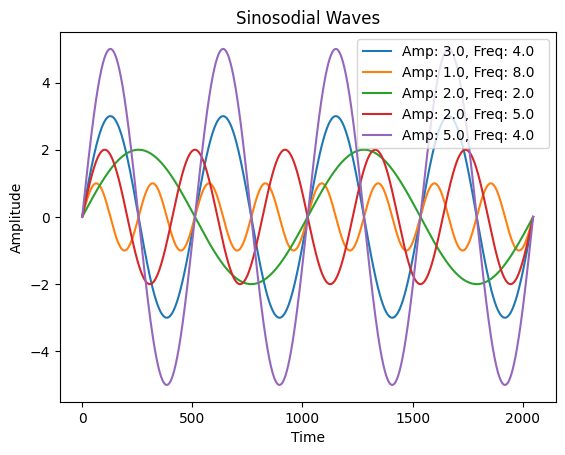

In [ ]:
np.random.seed(24)
n = 1000
tsteps = 2048
t = np.linspace(0, 2 * np.pi,tsteps)

X = np.zeros((n, tsteps), dtype=np.float32)
y = np.zeros((n, 2), dtype=np.float32)
T =t
for i in range(n):

    amplitude = np.random.randint(1, 10)
    frequency = np.random.randint(1,10)



    X[i, :] = amplitude * np.sin(frequency  * t)
    y[i, :] = [amplitude, frequency]

for i in range(5):
  amp = y[i, 0]
  freq = y[i, 1]
  plt.plot(X[i], label = f'Amp: {amp}, Freq: {freq}  ' )
  plt.title("Sinosodial Waves")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
plt.legend()
plt.show()
T = torch.from_numpy(T)

In [ ]:
dataset = torch.from_numpy(X)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
#### Regular AutoEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
decoder = make_decoder(latent_dim=2, orig_feat_dim=2048)
encoder = make_encoder(orig_feat_dim=2048)
encoder.to(device)
decoder.to(device)

# reconstruction loss
criterion = nn.MSELoss()


optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4,
)

#train_loader = DataLoader(your_dataset, batch_size=64, shuffle=True)

num_epochs = 1000

bar = tqdm(range(1, num_epochs+1))
# --- 2) Training loop --------------------------
for epoch in bar:
    encoder.train()
    dec.train()
    running_loss = 0.0

    for x_batch in train_loader:
        # if your DataLoader yields (data, labels), do: x_batch, _ = batch
        x_batch = x_batch.to(device).float()

        optimizer.zero_grad()

        # forward
        z = encoder(x_batch)            # -> (batch, latent_dim)
        x_recon = decoder(z)            # -> (batch, orig_feat_dim)

        # compute loss & step
        loss = criterion(x_recon, x_batch)
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * x_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    bar.set_description(f"[Epoch {epoch}/{num_epochs}]  Loss: {epoch_loss:.2f}")


[Epoch 1000/1000]  Loss: 101.04: 100%|██████████| 1000/1000 [01:57<00:00,  8.50it/s]


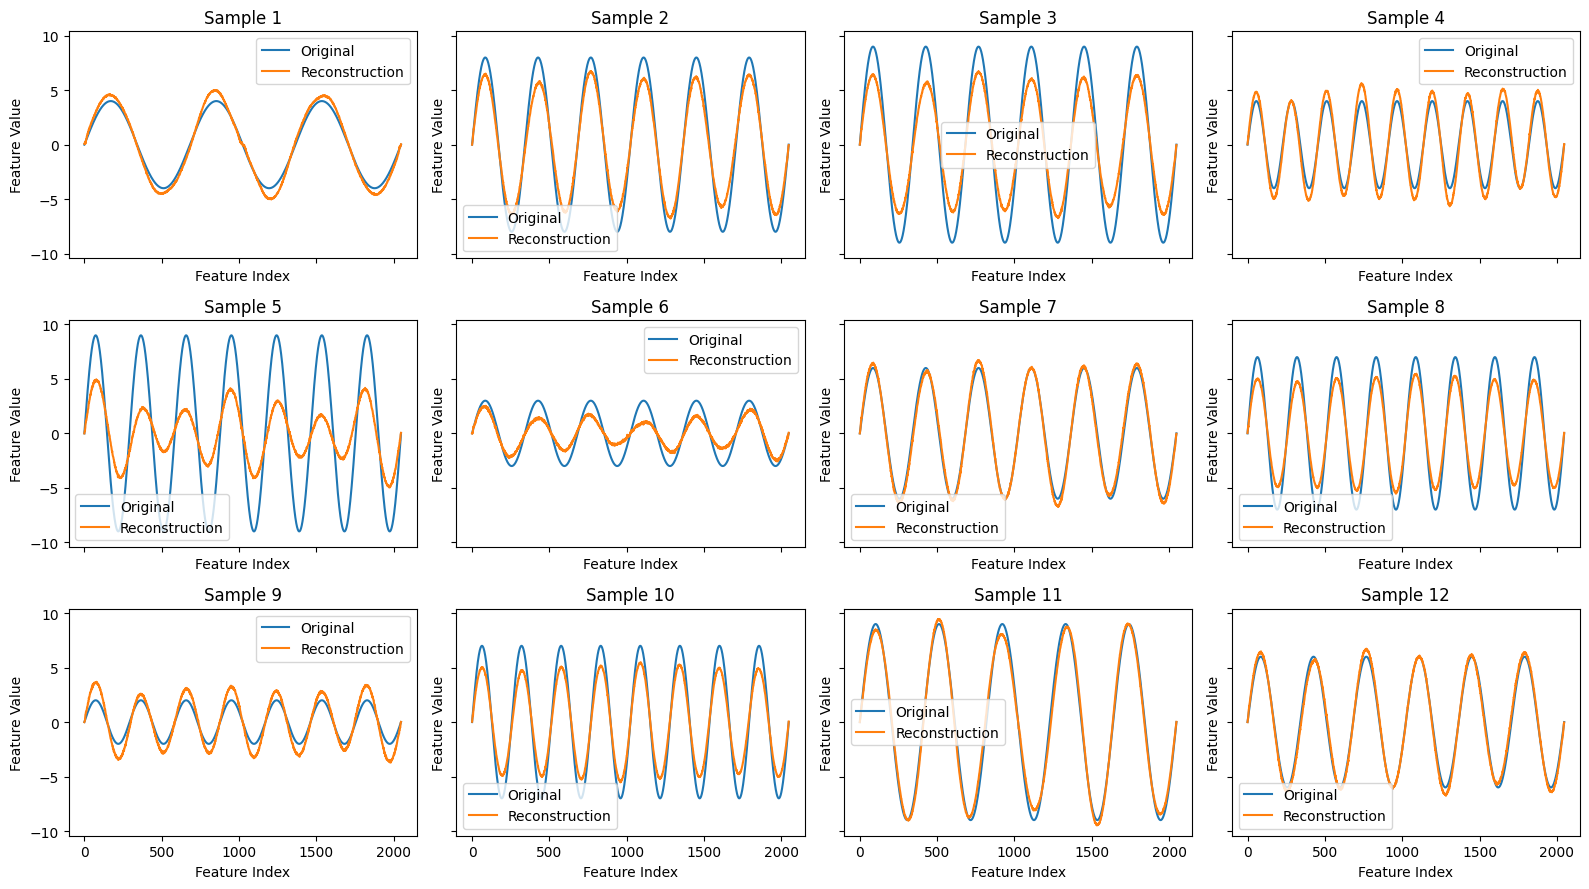

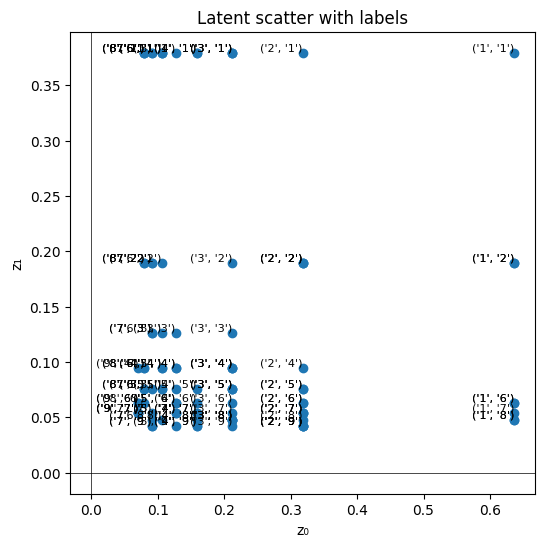

In [ ]:
plot_recon_panel(train_loader,encoder, decoder, indices=[i for i in range(1,13)], ncols=4, model = 0)
latent_scatter(encoder, X, y)

In [ ]:
# Time Conditional Decoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder2 = make_encoder(orig_feat_dim=2048)
encoder2.to(device)
dec = TimeConditionalDecoder(orig_feat_dim=2048, time_embed_dim=32)
dec.to(device)

# reconstruction loss
criterion = nn.MSELoss()




optimizer = torch.optim.Adam(
    list(encoder2.parameters()) + list(dec.parameters()),
    lr=1e-3,
)

#train_loader = DataLoader(your_dataset, batch_size=64, shuffle=True)

num_epochs = 1000
bar = tqdm(range(1, num_epochs+1))
# --- 2) Training loop --------------------------
for epoch in bar:
    encoder2.train()
    dec.train()
    running_loss = 0.0

    for x_batch in train_loader:
        # if your DataLoader yields (data, labels), do: x_batch, _ = batch
        x_batch = x_batch.to(device).float()

        optimizer.zero_grad()

        # forward
        z = encoder2(x_batch)            # -> (batch, latent_dim)

        t = torch.rand(x_batch.shape[0], 1).to(device)
        x_recon = dec(z, t)            # -> (batch, orig_feat_dim)

        # compute loss & step
        loss = criterion(x_recon, x_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    bar.set_description(f"[Epoch {epoch}/{num_epochs}]  Loss: {epoch_loss:.2f}")


[Epoch 1000/1000]  Loss: 349.58: 100%|██████████| 1000/1000 [02:06<00:00,  7.89it/s]


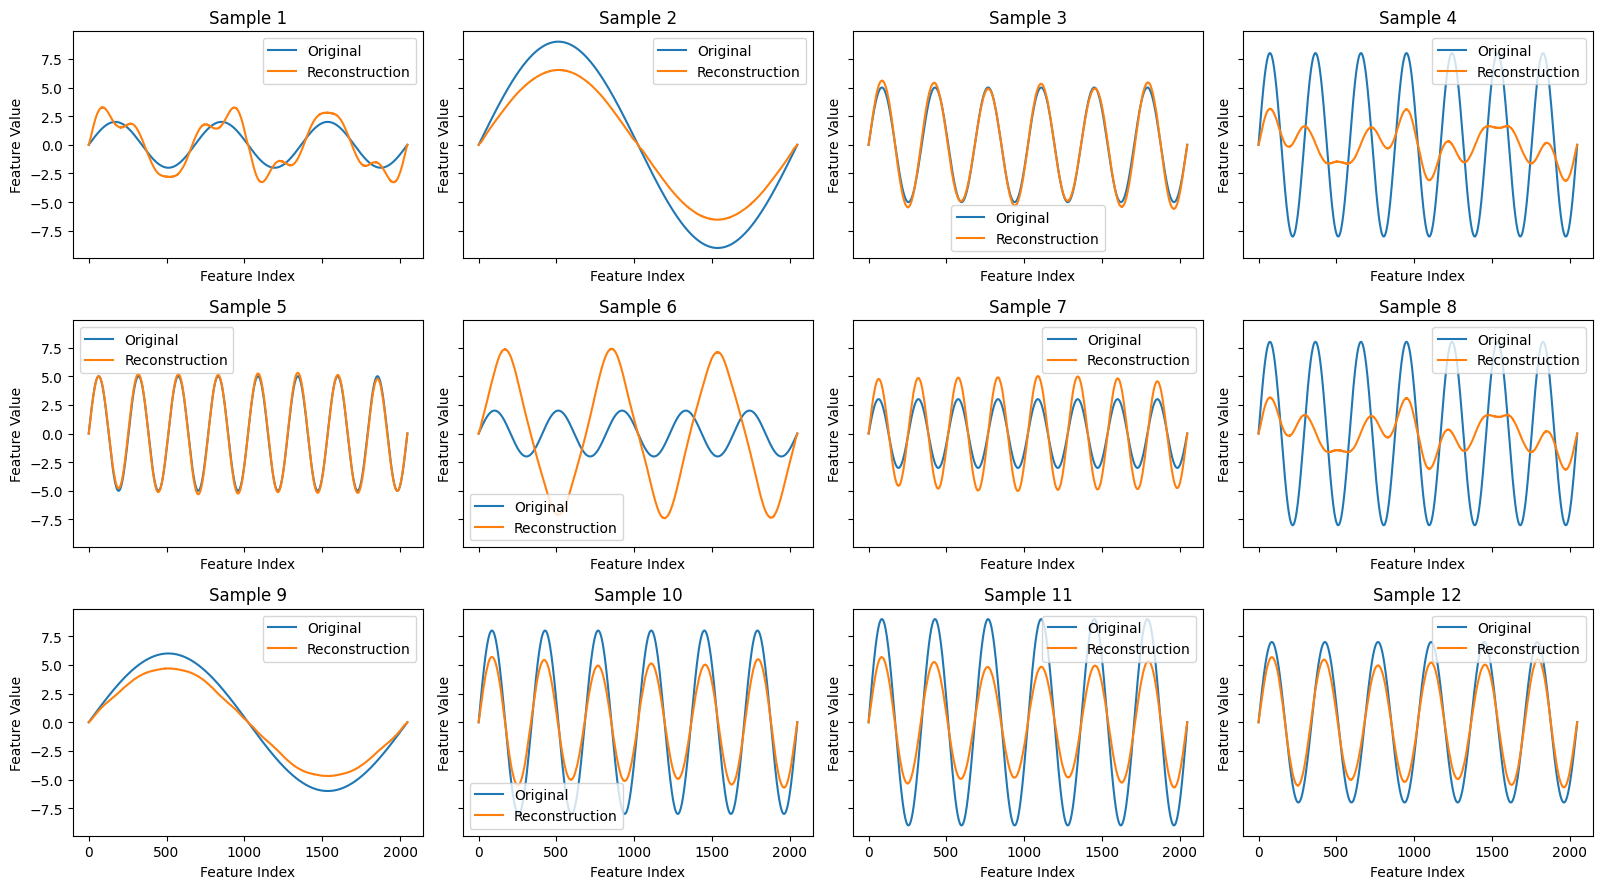

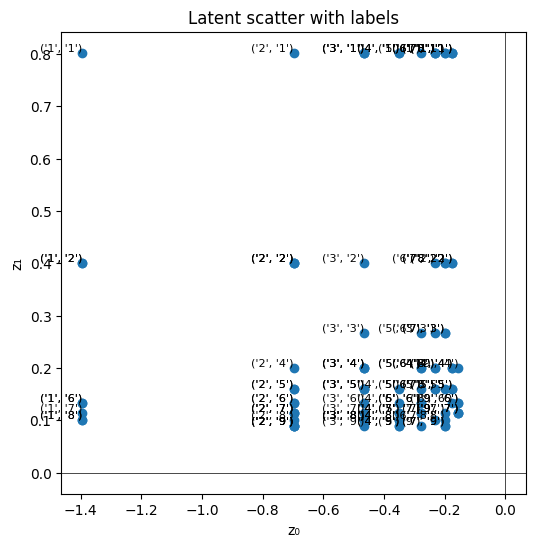

In [ ]:
plot_recon_panel(train_loader,encoder2, dec, indices=[i for i in range(1,13)], ncols=4, model = 1)
latent_scatter(encoder2, X, y)

In [ ]:
#Diffusion Guided AutoEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder3 = make_encoder(orig_feat_dim=2048)
encoder3.to(device)
diffdecoder = Decoder(din=2048, latent_dim=2, base_channels=32)
diffdecoder.to(device)

# reconstruction loss
criterion = nn.MSELoss()
criterion2 = nn.KLDivLoss()



optimizer = torch.optim.Adam(
    list(encoder3.parameters()) + list(diffdecoder.parameters()),
    lr=1e-4,
)

#train_loader = DataLoader(your_dataset, batch_size=64, shuffle=True)
num_timesteps = 2048
betas = torch.linspace(0.0001, 0.02, num_timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
num_epochs = 500
from tqdm import tqdm
bar = tqdm(range(1, num_epochs+1))

# --- 2) Training loop --------------------------
for epoch in bar:
    encoder3.train()
    diffdecoder.train()
    running_loss = 0.0

    for x_batch in train_loader:
        # if your DataLoader yields (data, labels), do: x_batch, _ = batch
        x_batch = x_batch.unsqueeze(1).to(device).float() # Shape: [batch, 1, 2048]
        batch_size = x_batch.shape[0]

        optimizer.zero_grad()

        t = torch.randint(0, num_timesteps, (batch_size,), device=device).long()

        noise = torch.randn_like(x_batch)
        sqrt_alphas_cumprod_t = alphas_cumprod[t].sqrt().view(batch_size, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = (1.0 - alphas_cumprod[t]).sqrt().view(batch_size, 1, 1)

        noisy_x = sqrt_alphas_cumprod_t * x_batch + sqrt_one_minus_alphas_cumprod_t * noise


        z = encoder3(x_batch.squeeze(1))

        x_recon = diffdecoder(noisy_x, z, t)


        loss = criterion(x_recon.squeeze(1), x_batch.squeeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    bar.set_description(f"[Epoch {epoch}/{num_epochs}]  Loss: {epoch_loss:.2f}")


[Epoch 500/500]  Loss: 30.35: 100%|██████████| 500/500 [20:18<00:00,  2.44s/it] 


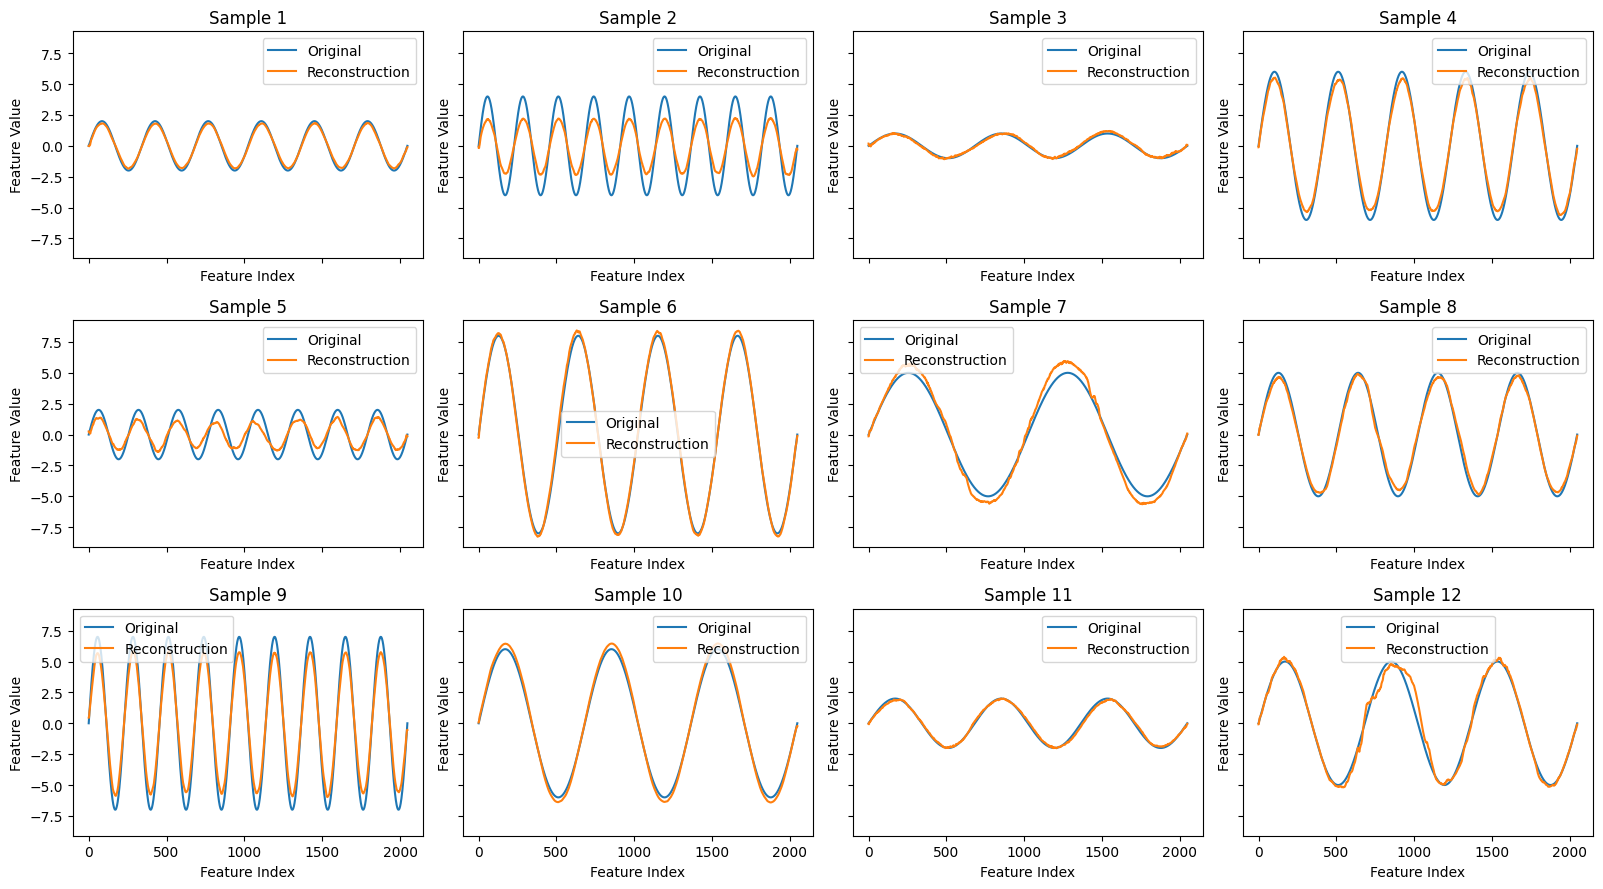

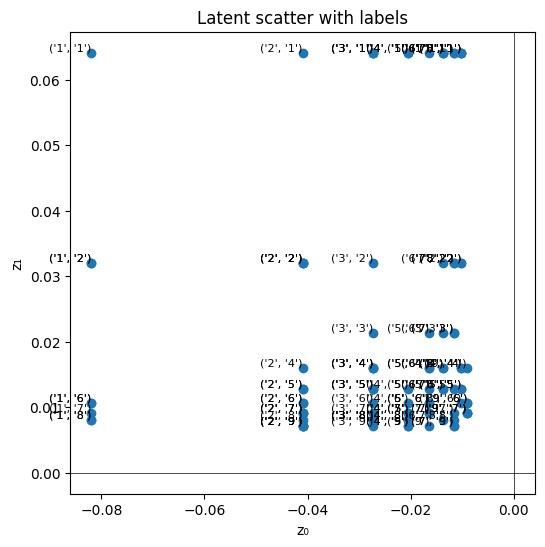

In [ ]:
plot_recon_panel(train_loader,encoder3, diffdecoder, indices=[i for i in range(1,13)], ncols=4, model = 2)
latent_scatter(encoder3, X, y)